## Import Libraries

In [27]:
import torch
import torchvision.transforms as transforms   
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import torchvision.models as models   
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [28]:
# import os
# import random
# import shutil

# # Set your original dataset directory and new directory to store the reduced dataset
# original_dataset_dir = "dataset/asl_alphabet_train"  # Replace with the actual path
# new_dataset_dir = "dataset/asl_alphabet_train_new"  # Where the reduced dataset will be saved
# target_image_count = 500  # Number of images to select per class

# # Create a new directory if it doesn't exist
# if not os.path.exists(new_dataset_dir):
#     os.makedirs(new_dataset_dir)

# # Iterate over each class folder
# for class_name in os.listdir(original_dataset_dir):
#     class_dir = os.path.join(original_dataset_dir, class_name)
    
#     # Check if it's a directory (i.e., class folder)
#     if os.path.isdir(class_dir):
#         # Get the list of all images in the class folder
#         all_images = os.listdir(class_dir)
        
#         # Randomly shuffle the list of images
#         random.shuffle(all_images)
        
#         # Select the first 'target_image_count' images
#         selected_images = all_images[:target_image_count]
        
#         # Create the corresponding directory in the new dataset folder
#         new_class_dir = os.path.join(new_dataset_dir, class_name)
#         if not os.path.exists(new_class_dir):
#             os.makedirs(new_class_dir)
        
#         # Copy the selected images to the new folder
#         for image in selected_images:
#             image_path = os.path.join(class_dir, image)
#             if os.path.isfile(image_path):
#                 shutil.copy(image_path, new_class_dir)

# print(f"Dataset reduced to {target_image_count} images per class.")


## Prepare Dataset

In [29]:
train_dir = 'dataset/asl_alphabet_train_new'

## Data Augmentation and Preprocessing

In [30]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],     # Imagenet mean
                         [0.229, 0.224, 0.225])     # Imagenet std
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=2)

class_names = train_dataset.dataset.classes  
print(f'Classes: {class_names}')
print(f'Total Classes: {len(class_names)}')

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total Classes: 29


## Load Pretrained Model

In [31]:
# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze early layers (optional - good if dataset is small)
for param in model.parameters():
    param.requires_grad = False
    
# Only unfreeze the classifier
for param in model.classifier.parameters():
    param.requires_grad = True
    
# Replace the final layer (fc) to match 29 classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Define Loss and Optimizer

In [32]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)

print('Loss function and optimizer set up successfully!')

Loss function and optimizer set up successfully!


## Train the Model

In [33]:
EPOCHS = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs,1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total 
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total 
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
               
        
print(f"Epoch [{epoch+1}/{EPOCHS}] - "
f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 10/10 - Validation: 100%|██████████| 91/91 [00:28<00:00,  3.19it/s]

Epoch [10/10] - Train Loss: 0.2306, Train Acc: 0.9265 | Val Loss: 0.9198, Val Acc: 0.9393


## Plot training and validation accuracy set

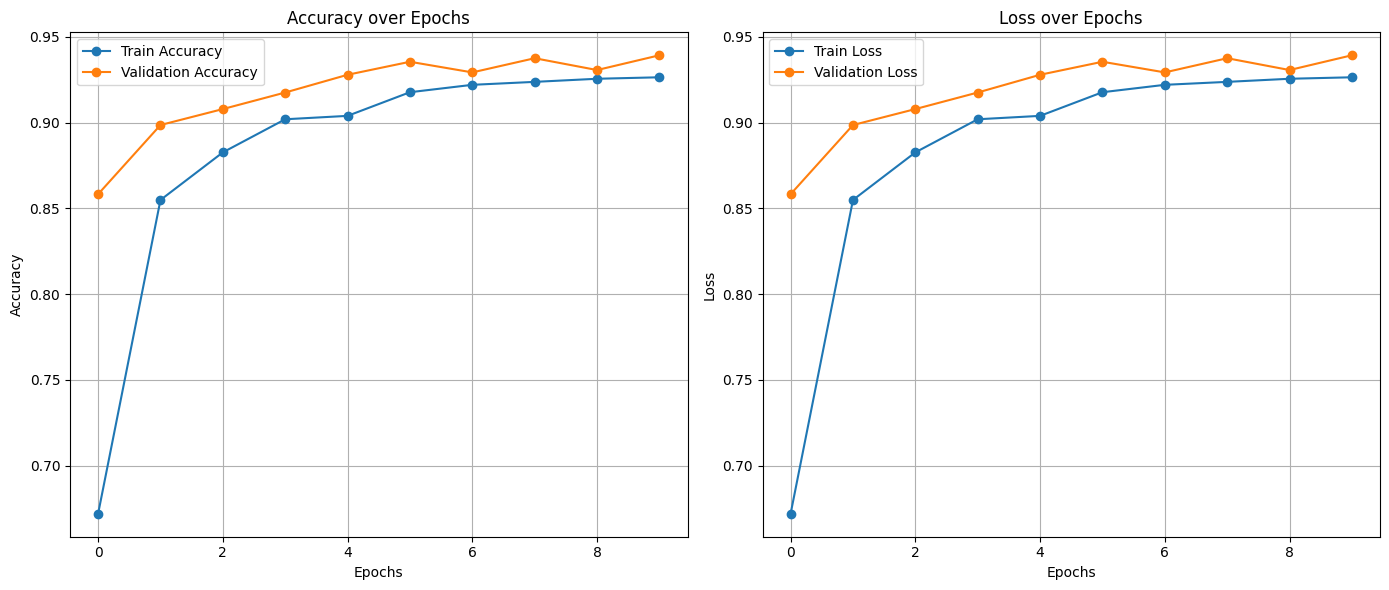

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy', marker = 'o')
plt.plot(val_accuracies, label='Validation Accuracy', marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Loss', marker = 'o')
plt.plot(val_accuracies, label='Validation Loss', marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Save the Model

In [36]:
torch.save(model.state_dict(), 'asl_transferlearning_model.pth')